# Нейрон с различными функциями активации

В этом задании нужно будет: 
- самостоятельно реализовать класс **`Neuron()`** с различными функциями активации (ReLU, LeakyReLU и ELU)

- обучить и протестировать этот класс на сгенерированных и реальных данных

**Достаточно реализовать ReLU и ещё одну из двух.**

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

В данном случае мы снова решаем задачу бинарной классификации (2 класса: 1 или 0). Мы уже выяснили (в ноутбуке про `logloss`), что плохо брать для классификации квадратичную функцию потерь, однако здесь для простоты возьмём её:

$$
Loss(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2
$$  

Здесь $w \cdot X_i$ - скалярное произведение, а $\hat{y_i} = \sigma(w \cdot X_i) =\frac{1}{1+e^{-w \cdot X_i}} $ - сигмоида ($i$ -- номер объекта в выборке). 

In [ ]:
def Loss(y_pred, y):
    y_pred = y_pred.reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    return 0.5 * np.mean((y_pred - y) ** 2)

Далее будут предложены несколько функций активации, и Вам нужно реализовать класс `Neuron` по аналогии с тем, как это было на семинаре. Сам принцип тот же, но меняются формула обновления весов и формула предсказания.

# **Нейрон с ReLU (Recitified Linear Unit)**

ReLU самая часто используемая (по крайней мере, пару лет назад) функция активации в нейронных сетях. Выглядит она очень просто:

\begin{equation*}
ReLU(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Или по-другому:

$$
ReLU(x) = \max(0, x)
$$

В (свободном) переводе Rectified Linear Unit = "Усечённая линейная функция". Собственно, мы по сути просто не даём проходить отрицательным числам.

Производная здесь берётся как производная от кусочно-заданной функции, то есть на участках, где функция гладкая, и в нуле её доопредляют нулём:

\begin{equation*}
ReLU'(x) = 
 \begin{cases}
   0, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Подставим ReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ReLU(w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
    y_i^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

(помните, что $w \cdot X_i$ -- это число в данном случае (результат скалярного произведения двух векторов)).

Тогда формула для обновления весов при градиентном спуске будет такая (в матричном виде, рекмоендуем вывести самим то, как это получается из формулы для одного объекта):

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   0, &{w \cdot X_i \le 0}\\
   \frac{1}{n} X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

(напоминаем, что здесь $w \cdot X$ -- матричное произведение вектора $w$ (ведь вектор -- тоже матрица, не так ли?) и матрицы $X$ )

Почему в первом случае будет 0? Потому что в формулу $y_i^2$ не входят веса , а мы берём производную именно по весам $w$.

* Реализуйте ReLU и её производную:

In [ ]:
def relu(x):
    """ReLU-функция"""
    return x * (x > 0)

In [ ]:
def relu_derivative(x):
    """Производная ReLU"""
    if x <= 0:
      return 0
    else:
      return 1 

Теперь нужно написать нейрон с ReLU. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronReLU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return relu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
    
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        sigma = self.activate(X @ self.w + self.b)
        self.w = self.w - learning_rate * (X.T @ (sigma - y)) / n
        self.b = self.b - learning_rate * np.mean(sigma - y)
    
        
    def fit(self, X, y, num_epochs=5000):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """

        self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
        self.b = 0  # смещение
        loss_values = []
        for i in range(num_epochs):
            # предсказания с текущими весами
            y_pred = self.forward_pass(X)
            # считаем функцию потерь с текущими весами
            loss_values.append(Loss(y_pred, y))
            # обновляем веса по формуле градиентного спуска
            self.backward_pass(X, y, y_pred)

        return loss_values

    def predict(self, X):
      
      pred = np.round(self.forward_pass(X))
      
      return pred

##**Тестирование нейрона с ReLU**  

Здесь вам нужно самим протестировать новый нейрон **на тех же данных** ("Яблоки и Груши" и "Голос") по аналогии с тем, как это было проделано с перцептроном.
В итоге нужно вывести: 
* график, на котором будет показано, как изменяется функция потерь $Loss$ в зависимости от числа итераций обучения
* график с раскраской выборки нейроном

***ПРИМЕЧАНИЕ***: пожалуйста, почаще проверяйте `.shape` у матриц и векторов: `self.w`, `X` и `y` внутри класса. Очень часто ошибка решается транспонированием или `.reshape()`'ом. Не забывайте проверять, что на что Вы умножаете и какой вектор (какой размер) хотите получить на выходе -- это очень помогает не запутаться.

### **Яблоки и груши**

**Исходнные датасет**

In [ ]:
data = pd.read_csv("apples_pears.csv")

**Исходный датасет**

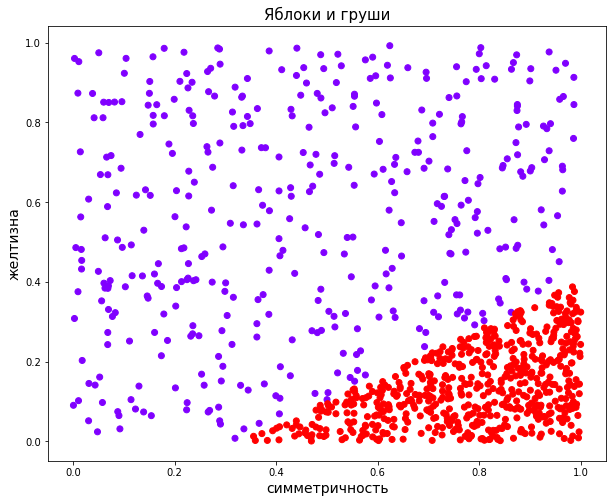

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [ ]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))

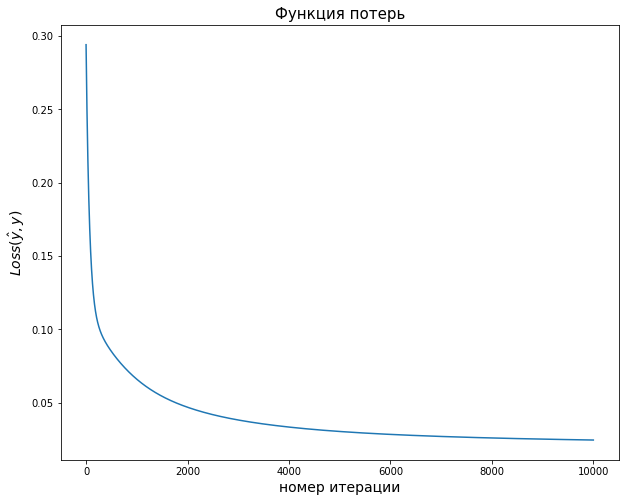

In [ ]:
neuron = NeuronReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Всё просто -- если присмотреться, то видно, что self.w и self.b иницилизируются нулями в начале `.fit()`-метода. Если расписать, как будет идти обновление, то видно, что из-за ReLU веса просто-напросто не будут обновляться, если начать с инициализации нулями. 

Это -- одна из причин, по которой в нейронных сетях веса инициализируют случаными числами (обычно из отрезка [0, 1)).

Обучите нейрон, инициализировав случайно веса (поставьте 10000 итераций). 

Закомментируйте инициализацию нулями в функции `.fit()` класса `NeuronReLU` 

Посмотрим, как предсказывает этот нейрон:

**Предсказанный датасет**

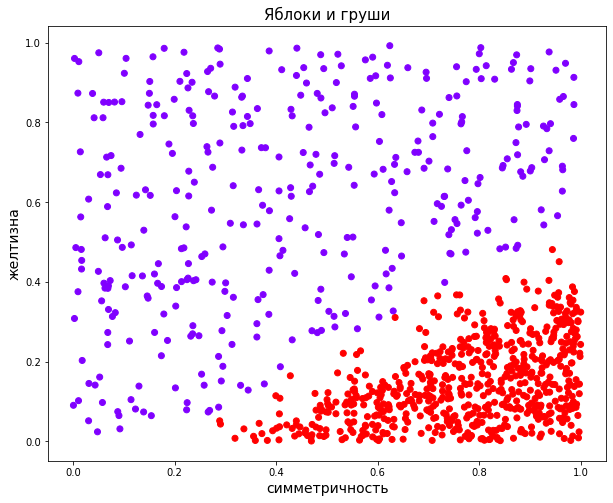

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=np.array(neuron.forward_pass(X) > 0.5).ravel(), cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.2)

In [ ]:
test_Neuron = NeuronReLU()
test_loss = test_Neuron.fit(X_train, y_train, num_epochs = 50000)
y_pred_relu = test_Neuron.predict(X_test)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

In [ ]:
acc_apple_pears_relu = accuracy_score(y_test, y_pred_relu) * 100
print('Точность предсказания нейрона: ' + str(acc_apple_pears_relu) + '%')

Точность предсказания нейрона: 96.0%


### **Голос**

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('voice.csv')
data['label'] = data['label'].apply(lambda x: 1 if x == 'male' else 0)

In [ ]:
X = data.drop(columns='label')
y = data['label']

In [ ]:
X = StandardScaler().fit_transform(X.values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

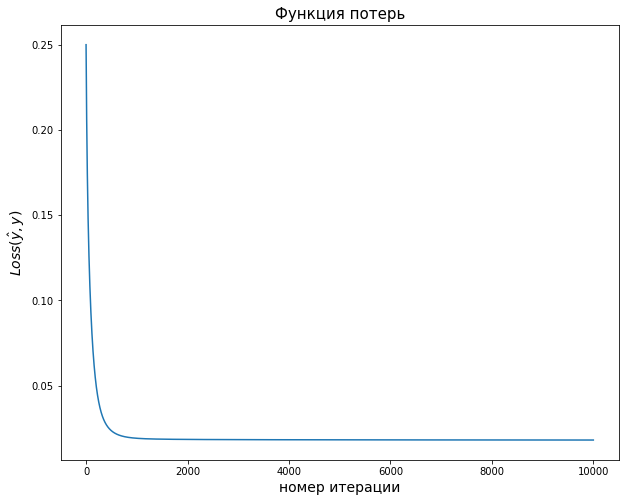

In [ ]:
neuron_relu_v = NeuronReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron_relu_v.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

In [ ]:
test_voice_neuron = NeuronReLU()

loss_voice = test_voice_neuron.fit(X_train, y_train.values)

y_pred = test_voice_neuron.predict(X_test)

In [ ]:
acc_voice_relu = accuracy_score(y_test, y_pred) * 100
print('Точность предсказания нейрона: ' + str(round(acc_voice_relu, 2)) + '%')

Точность предсказания нейрона: 97.79%


**Плюсы ReLU:**

* дифференцируемая (с доопределе
нием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде

**Возможные минусы ReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* зануляет все отрицательные входы, тем самым веса у занулённых нейронов могут часто *не обновляться*, эту проблему иногда называют *мёртвые нейроны*

С последней проблемой можно побороться, а именно:

# **Нейрон с LeakyReLU (Leaky Recitified Linear Unit)**

LeakyReLU очень слабо отличается от ReLU, но часто помогает сети обучаться быстрее, поскольку нет проблемы "мёртвых нейронов":

\begin{equation*}
LeakyReLU(x) =
 \begin{cases}
   \alpha x, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
LeakyReLU'(x) = 
 \begin{cases}
   \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

График этой функции:

<img src="https://cdn-images-1.medium.com/max/1600/0*UtLlZJ80TMIM7kXk." width=400 height=300>

Подставим LeakyReLu в Loss:

$$
Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (LeakyReLU(w \cdot X_i) - y_i)^2 =
\begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha \cdot w \cdot X_i - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}
$$  

Формула для обновления весов при градиентном спуске:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   \alpha X_i^T (w \cdot X_i - y), &{w \cdot X_i \le 0}\\
    X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте LeakyReLU и её производную:

In [ ]:
def leaky_relu(x, alpha=0.01):
    """LeakyReLU-функция"""
    return np.where(x <= 0, alpha*x, x)

In [ ]:
def leaky_relu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    return np.where(x <= 0, alpha, x)

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronLeakyReLU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return leaky_relu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)

        return y_pred.reshape(-1, 1)
        
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        sigma = self.activate(X @ self.w + self.b)
        self.w = self.w - learning_rate * (X.T @ (sigma - y)) / n
        self.b = self.b - learning_rate * np.mean(sigma - y)
    
    
    def fit(self, X, y, num_epochs=5000):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
        self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            Loss_values.append(Loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
        
        return Loss_values
        
 
    def predict(self, X):
      
      pred = np.round(self.forward_pass(X))
      
      return pred

**Плюсы LeakyReLU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU

**Возможные минусы LeakyReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* немного не устойчива к "шуму" (см. лекции Стэнфорда)

##**Тестирование нейрона с LeakyReLu**

### **Яблоки и Груши**

In [ ]:
data = pd.read_csv("apples_pears.csv")

**Исходный датасет**

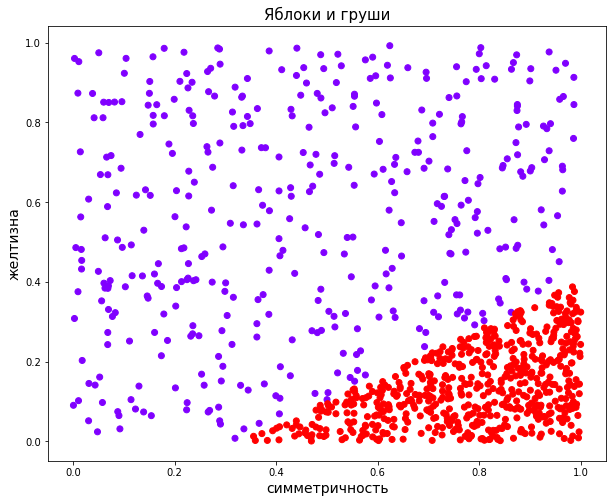

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [ ]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))

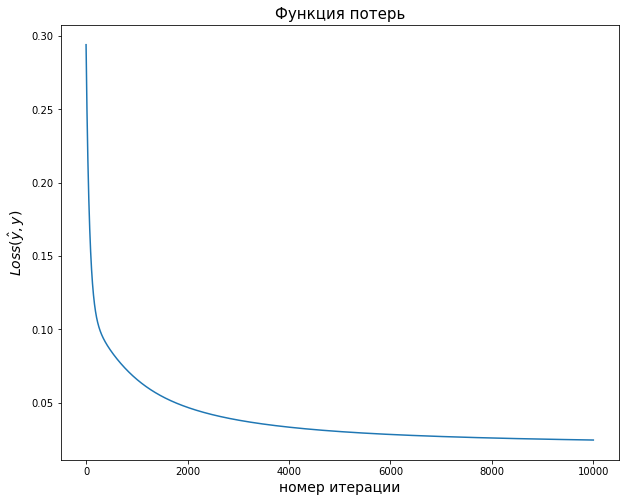

In [ ]:
neuron = NeuronLeakyReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

**Предсказаный датасет**

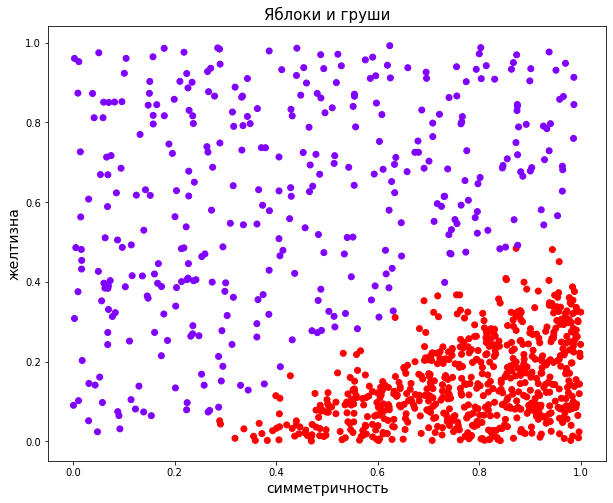

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=np.array(neuron.forward_pass(X) > 0.5).ravel(), cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [ ]:
test_Neuron = NeuronLeakyReLU()
test_loss = test_Neuron.fit(X_train, y_train, num_epochs = 50000)
y_pred_Lrelu = test_Neuron.predict(X_test)

In [ ]:
acc_apple_pears_Leakyrelu = accuracy_score(y_test, y_pred_Lrelu) * 100
print('Точность предсказания нейрона: ' + str(acc_apple_pears_Leakyrelu) + '%')

Точность предсказания нейрона: 97.63406940063092%


### **Голос**

In [ ]:
data = pd.read_csv('voice.csv')
data['label'] = data['label'].apply(lambda x: 1 if x == 'male' else 0)

In [ ]:
X = data.drop(columns='label')
y = data['label']

In [ ]:
X = StandardScaler().fit_transform(X.values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

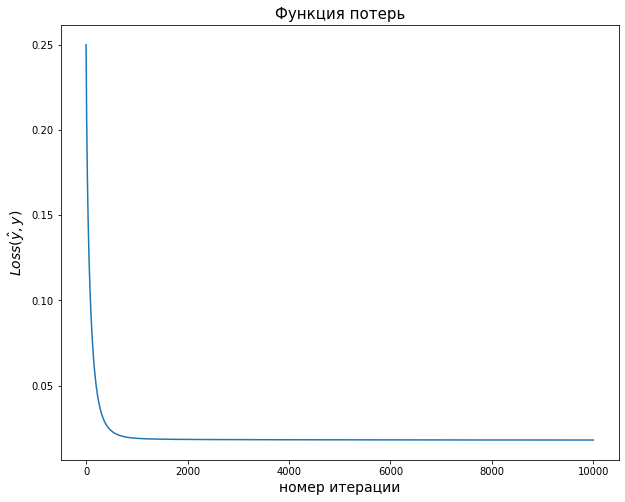

In [ ]:
neuron_Lrelu_v = NeuronLeakyReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron_Lrelu_v.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

In [ ]:
test_voice_neuron = NeuronLeakyReLU()

loss_voice = test_voice_neuron.fit(X_train, y_train.values)

y_pred = test_voice_neuron.predict(X_test)

In [ ]:
acc_voice_Lrelu = accuracy_score(y_test, y_pred) * 100
print('Точность предсказания нейрона: ' + str(round(acc_voice_Lrelu, 2)) + '%')

Точность предсказания нейрона: 97.0%


# **Результататы из коробки для Relu и LeakyRelu**

## **Яблоки и груши**

In [ ]:
data = pd.read_csv("apples_pears.csv")

In [ ]:
data.head()

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0


In [ ]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.2)

In [ ]:
# Импортируем сам keras
import keras
# Последовательный тип модели
from keras.models import Sequential
# Импортируем полносвязный слой, слои активации и слой, превращающий картинку в вектор
from keras.layers import Dense, Activation

### **Relu**

In [ ]:
relu_model = Sequential()

relu_model.add(Dense(units=1, input_shape=(2,), activation = 'relu'))
relu_model.compile(metrics = ['accuracy'], loss='mse')

In [ ]:
relu_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rm = relu_model.fit(X_train, y_train, 
                    epochs=500, 
                    batch_size = 32)

Epoch 1/500
7/7 [==============================] - 0s 2ms/step - loss: 0.2406 - accuracy: 0.4300
Epoch 2/500
7/7 [==============================] - 0s 2ms/step - loss: 0.2279 - accuracy: 0.4750
Epoch 3/500
7/7 [==============================] - 0s 2ms/step - loss: 0.2186 - accuracy: 0.5050
Epoch 4/500
7/7 [==============================] - 0s 2ms/step - loss: 0.2104 - accuracy: 0.5350
Epoch 5/500
7/7 [==============================] - 0s 2ms/step - loss: 0.2031 - accuracy: 0.5700
Epoch 6/500
7/7 [==============================] - 0s 2ms/step - loss: 0.1971 - accuracy: 0.5850
Epoch 7/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1906 - accuracy: 0.6450
Epoch 8/500
7/7 [==============================] - 0s 2ms/step - loss: 0.1843 - accuracy: 0.6650
Epoch 9/500
7/7 [==============================] - 0s 2ms/step - loss: 0.1793 - accuracy: 0.6950
Epoch 10/500
7/7 [==============================] - 0s 2ms/step - loss: 0.1735 - accuracy: 0.7300
Epoch 11/500
7/7 [===========

In [ ]:
results_relu_apple_pears = relu_model.evaluate(X_test, y_test, batch_size=32)

25/25 [==============================] - 0s 1ms/step - loss: 0.0422 - accuracy: 0.9688


In [ ]:
print("Точность предсказания: " + str(round(results_relu_apple_pears[1], 4) * 100) + '%')

Точность предсказания: 96.88%


### **LeakyRelu**

In [ ]:
from keras.layers import LeakyReLU

In [ ]:
Leakyrelu_model = Sequential()

Leakyrelu_model.add(Dense(units=1, input_shape=(2,), activation = LeakyReLU()))
Leakyrelu_model.compile(metrics = ['accuracy'], loss='mse')

In [ ]:
Leakyrelu_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rl = Leakyrelu_model.fit(X_train, y_train, 
                    epochs=500, 
                    batch_size = 32)

Epoch 1/500
7/7 [==============================] - 0s 2ms/step - loss: 0.0597 - accuracy: 0.9300
Epoch 2/500
7/7 [==============================] - 0s 2ms/step - loss: 0.0596 - accuracy: 0.9350
Epoch 3/500
7/7 [==============================] - 0s 2ms/step - loss: 0.0596 - accuracy: 0.9350
Epoch 4/500
7/7 [==============================] - 0s 2ms/step - loss: 0.0596 - accuracy: 0.9350
Epoch 5/500
7/7 [==============================] - 0s 2ms/step - loss: 0.0595 - accuracy: 0.9350
Epoch 6/500
7/7 [==============================] - 0s 2ms/step - loss: 0.0596 - accuracy: 0.9350
Epoch 7/500
7/7 [==============================] - 0s 2ms/step - loss: 0.0595 - accuracy: 0.9350
Epoch 8/500
7/7 [==============================] - 0s 2ms/step - loss: 0.0595 - accuracy: 0.9350
Epoch 9/500
7/7 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 0.9350
Epoch 10/500
7/7 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 0.9350
Epoch 11/500
7/7 [===========

In [ ]:
results_LR_apple_pears = Leakyrelu_model.evaluate(X_test, y_test, batch_size=32)

25/25 [==============================] - 0s 1ms/step - loss: 0.0503 - accuracy: 0.9538


In [ ]:
print("Точность предсказания: " + str(round(results_LR_apple_pears[1], 5) * 100) + '%')

Точность предсказания: 95.375%


## **Голос**

In [ ]:
data = pd.read_csv('voice.csv')
data['label'] = data['label'].apply(lambda x: 1 if x == 'male' else 0)

In [ ]:
X = data.drop(columns='label')
y = data['label']

In [ ]:
X = StandardScaler().fit_transform(X.values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### **Relu**

In [ ]:
relu_model_voice = Sequential()

relu_model_voice.add(Dense(units=1, input_shape=(20,), activation = 'relu'))
relu_model_voice.compile(metrics = ['accuracy'], loss='mse')

In [ ]:
relu_model_voice.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rm_v = relu_model_voice.fit(X_train, y_train, 
                    epochs=500, 
                    batch_size = 32)

Epoch 1/500
80/80 [==============================] - 0s 1ms/step - loss: 0.5780 - accuracy: 0.6669
Epoch 2/500
80/80 [==============================] - 0s 1ms/step - loss: 0.3583 - accuracy: 0.6725
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.2751 - accuracy: 0.7159
Epoch 4/500
80/80 [==============================] - 0s 1ms/step - loss: 0.2116 - accuracy: 0.7810
Epoch 5/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1686 - accuracy: 0.8311
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1390 - accuracy: 0.8635
Epoch 7/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1171 - accuracy: 0.8867
Epoch 8/500
80/80 [==============================] - 0s 1ms/step - loss: 0.0976 - accuracy: 0.9045
Epoch 9/500
80/80 [==============================] - 0s 1ms/step - loss: 0.0799 - accuracy: 0.9238
Epoch 10/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0666 - accuracy: 0.9396
Epoch 11/

In [ ]:
results_relu_v = relu_model_voice.evaluate(X_test, y_test, batch_size=32)

20/20 [==============================] - 0s 1ms/step - loss: 0.0424 - accuracy: 0.9621


In [ ]:
print("Точность предсказания: " + str(round(results_relu_v[1], 5) * 100) + '%')

Точность предсказания: 96.21499999999999%


### **LeakyRelu**

In [ ]:
Leakyrelu_model_voice = Sequential()

Leakyrelu_model_voice.add(Dense(units=1, input_shape=(20,), activation = LeakyReLU()))
Leakyrelu_model_voice.compile(metrics = ['accuracy'], loss='mse')

In [ ]:
Leakyrelu_model_voice.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rl_v = Leakyrelu_model_voice.fit(X_train, y_train, 
                    epochs=500, 
                    batch_size = 32)

Epoch 1/500
80/80 [==============================] - 0s 1ms/step - loss: 0.6185 - accuracy: 0.5454
Epoch 2/500
80/80 [==============================] - 0s 1ms/step - loss: 0.4524 - accuracy: 0.6448
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.3428 - accuracy: 0.7147
Epoch 4/500
80/80 [==============================] - 0s 2ms/step - loss: 0.2514 - accuracy: 0.7956
Epoch 5/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1819 - accuracy: 0.8567
Epoch 6/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1296 - accuracy: 0.8923
Epoch 7/500
80/80 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.9132
Epoch 8/500
80/80 [==============================] - 0s 1ms/step - loss: 0.0684 - accuracy: 0.9317
Epoch 9/500
80/80 [==============================] - 0s 1ms/step - loss: 0.0526 - accuracy: 0.9522
Epoch 10/500
80/80 [==============================] - 0s 1ms/step - loss: 0.0448 - accuracy: 0.9688
Epoch 11/

In [ ]:
results_Leakyrelu_v = Leakyrelu_model_voice.evaluate(X_test, y_test, batch_size=32)

20/20 [==============================] - 0s 1ms/step - loss: 0.0464 - accuracy: 0.9637


In [ ]:
print("Точность предсказания: " + str(round(results_Leakyrelu_v[1], 5) * 100) + '%')

Точность предсказания: 96.372%


# **ИТОГ**

In [ ]:
result_fruts = pd.Series([acc_apple_pears_relu, acc_apple_pears_Leakyrelu, results_relu_apple_pears[1] * 100, results_LR_apple_pears[1] * 100], index = ['MY_Relu', 'MY_LeakyRelu', 'Keras_Relu', 'Keras_LeakyRelu'], name = "apple_and_pears")

In [ ]:
result_voice = pd.Series([acc_voice_relu, acc_voice_Lrelu, results_relu_v[1] * 100, results_Leakyrelu_v[1] * 100], index = ['MY_Relu', 'MY_LeakyRelu', 'Keras_Relu', 'Keras_LeakyRelu'], name = "voice")

In [ ]:
pd.concat([result_fruts, result_voice], axis = 1)

,apple_and_pears,voice
MY_Relu,96.000000,97.791798
MY_LeakyRelu,97.634069,97.003155
Keras_Relu,96.875000,96.214509
Keras_LeakyRelu,95.375001,96.372241
